# Loading a soundfile

In [5]:
import keras
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
# on hkmac - env is "nd"

In [6]:
# make a Python list of the files in the directory
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
import os
def findfiles(directory):
    objects = os.listdir(directory)  # find all objects in a dir

    files = []
    for i in objects:  # check if very object in the folder ...
        if isFile(directory + i):  # ... is a file.
            files.append(i)  # if yes, append it.
    return files

def isFile(object):
    try:
        os.listdir(object)  # tries to get the objects inside of this object
        return False  # if it worked, it's a folder
    except Exception:  # if not, it's a file
        return True

In [7]:
soundfiles_dir = "/Users/hkmac/Dropbox (Personal)/mir2018/musicpygame/note_evaluation/soundfile_sch/"
soundfiles = findfiles(soundfiles_dir)
print(len(soundfiles))

48


In [8]:
soundfile = soundfiles[np.random.randint(len(soundfiles))]
print(soundfile)

C4_60_65_67_71.wav


# Reading the soundfile

In [9]:
def read_soundfile(soundfile):
    audio,sr = sf.read(soundfiles_dir + soundfile)
    print(np.shape(audio))
    sample = audio[:,0]
    print(np.shape(sample))
    plt.plot(sample)
    plt.show()
    return sample

(53056, 2)
(53056,)


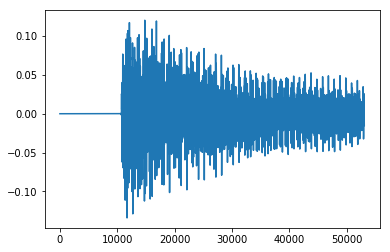

In [10]:
sample = read_soundfile(soundfile)

# Identify onset, splice, and make spectrogram

In [26]:
# Functions for onset detecti    midi_instructions = track, channel, time, duration,volume[0], tempo[0]on

def rcoeff_(snippet):
    return np.corrcoef(snippet, np.arange(len(snippet)))[0, 1]

rcoeff = np.vectorize(rcoeff_, signature='(n)->()')

def divide_chunks(signal, intervals, snippet_size):
# yield successive n-sized chunks from l.
    for i in range(0, len(signal) - snippet_size, intervals):
        # looping till the end of the array
        yield signal[i:i + snippet_size]
        
def max_to_one(arr):
    '''Scale the maximum of an array to one'''
    return np.divide(arr, np.max(np.absolute(arr)))

def detect_onset_given_entire_signal(signal):
    '''
    Onset detection function. Could be replaced with a better one.
    Returns two signals, 
    - a short one (fixed at length 4096) for a standard note evaluation algorithm, 
    - a long one (usually 3*4096) for making spectrograms and applying machine learning algorithms like CNN.
    (Why not standardise them, return the longer one instead?)
    Onset detection is carried out every 32 points so we do not have to calculate the r-value of 4096 points at every point.
    '''
#     print(len(signal))
    signal_cs = np.cumsum(np.absolute(signal))
    signal_cs = np.add(signal_cs, np.random.randn(len(signal_cs)))
#     print(len(signal_cs))
    signal_chunk_sum = signal_cs[4096:] - signal_cs[:-4096]
    snippets = np.array(list(divide_chunks(signal_chunk_sum, 32, 4096)))
    signal_rcoeff = rcoeff(snippets)

#     print("loc")
#     print(signal_rcoeff)
#     print(np.where(signal_rcoeff>0.8)[0][0])
    location = np.where(signal_rcoeff>0.8)[0][0]
    start_pt, end_pt = location*32+7168, location*32+7168+4096
    map_start_pt = location*32+7168-3*4096
    if map_start_pt < 0:
        print("x")
        map_start_pt = 0
        
    return signal[start_pt:end_pt], signal[map_start_pt:end_pt]

x
15456


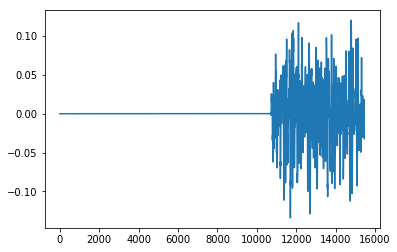

In [40]:
signal_to_map = detect_onset_given_entire_signal(sample)[1]
print(len(signal_to_map))
plt.plot(signal_to_map)
plt.show()

In [46]:
import librosa
def convert_to_CQT(signal_to_map):
    fmin = librosa.core.note_to_hz("B3")
    cqt_array = librosa.cqt(signal_to_map, sr=44100, hop_length=2**7, bins_per_octave=36, fmin=fmin, n_bins=108)
    CQT = librosa.magphase(cqt_array)[0][:108,-108:]
    print(np.shape(CQT))
    return CQT


In [47]:
spectro = convert_to_CQT(signal_to_map)

(108, 108)


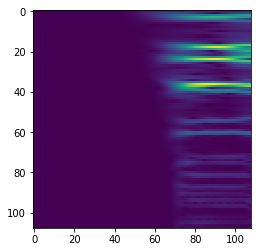

In [48]:
plt.imshow(spectro)

In [50]:
spectro = spectro.reshape(1,108,108,1)

# Setup model and predict notes

In [36]:
def setup_classifier(model_path, weight_path):
    yaml_file = open(model_path, 'r')
    loaded = yaml_file.read()
    yaml_file.close()
    classifier = keras.models.model_from_yaml(loaded)
    classifier.load_weights(weight_path)
    return classifier

classifier = setup_classifier(model_path="model.yaml", weight_path="weight-25800-CNN_E_good.hdf5")
# Loading the classifier takes time. It should not be done every time when the program runs.

In [37]:
def predict(data, classifier):
    result = classifier.predict(data)[0].tolist()
    output = 'C'
    possible = 'possible notes: '
    for i in range(len(result)):
        if result[i] < 0.01:
            result[i] = 0
        elif result[i] > 0.99:
            result[i] = 1
            output += '_{}'.format(i+60)
        else:
            possible += '_{}__{}'.format(i+60, result[i])
    print(output)
    print(possible)
    return result

In [38]:
result = predict(spectro, classifier)

C_60_65_67_71
possible notes: 


In [39]:
print(soundfile)

C4_60_65_67_71.wav
